# Group k-fold linear regression by habitat

## 1. Load packages and custom functions

In [55]:
# -*- coding: utf-8 -*-
"""
Updated 20 January 2025

"""

from IPython import get_ipython
print(__doc__)

# Clear all the variables
get_ipython().run_line_magic('reset', '-sf')

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")
# from pathlib import Path 
import matplotlib.pyplot as plt
import pandas as pd 
from pathlib import Path 
import os
import sys
import numpy as np
from numpy import mean
import statsmodels.api as sm
import scipy.stats as stats

import seaborn as sns

# scikit-learn (machine learning) package
from sklearn.preprocessing import (StandardScaler)
from sklearn.linear_model import  HuberRegressor

from sklearn.model_selection import RepeatedKFold, permutation_test_score, GroupKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

# Close all the figures (like in Matlab)
plt.close("all")

# Import configuration file
sys.path.append(str(Path('../src')))
import config as cfg


Updated 20 January 2025




#### Custom functions

In [56]:
def groupkfold_regression (
                indices, 
                gt, 
                df, 
                model,
                seed = 1979, 
                verbose=False) :
        """
        Perform a GroupKFold cross-validation on a regression model.

        Parameters
        ----------
        indices : list
            List of indices to use as predictors.
        gt : str
            Name of the column containing the ground truth.
        df : pandas.DataFrame
            Dataframe containing the data.
        model : sklearn.linear_model
            Model to use for the regression.
        seed : int, optional
            Seed for the random number generator. The default is 1979.
        verbose : bool, optional
            Print the results. The default is False.
        
        Returns
        -------
        df_metrics_kfold : pandas.DataFrame
            Dataframe containing the metrics.
        models_list : list
            List of the best models.
        
        """

        # initialize the dataframe to store the metrics
        df_metrics_kfold = pd.DataFrame(columns=[
                                        'INDICE', 
                                        'CCC', 'CCC_L_SHIFT','CCC_S_SHIFT', 'CCC_BIAS', 'ME', 'MAE', 'RMSE', 'R2', 'MEDIAN_AE', 'pvalue']) 
        
        # empty dictionnary to store the best model for each indice
        models_list = []
        
        # concatenate the list CONFIG['list_indices'] to a string
        INDICE_STR = '_'.join(indices)

        # set a number to each habitat in order to have a unique group for each habitat
        groups = df['habitat'].astype('category').cat.codes
        if verbose : print(f'The groups are {groups.unique()}')  

        # 1. Set the data
        if len(indices) == 1 :
            X_kfold = df[indices].to_numpy().reshape(-1,1)
        else :
            X_kfold = df[indices].to_numpy()
        
        y_kfold = df[gt].to_numpy()

        # 2. Create the kfold cross-validation 
        cv = GroupKFold(n_splits=groups.nunique())

        # 3. Train and test model with repeated cross-validation
        scoring = {
                'MAE': 'neg_mean_absolute_error',
                'MEDIAN_AE': 'neg_median_absolute_error',
                'RMSE': 'neg_root_mean_squared_error',
                'ME': make_scorer(mean_error),
                'CCC': make_scorer(ccc_est),
                'CCC_L_SHIFT': make_scorer(ccc_l_shift),
                'CCC_S_SHIFT': make_scorer(ccc_s_shift),
                'CCC_BIAS': make_scorer(ccc_bias),
                'R2': 'r2'
                }
        
        # BUG cross_validate does not take CV but rather use the default parameter which is n_splits=5        
        scores = cross_validate(model, 
                                X_kfold, 
                                y_kfold, 
                                scoring=scoring, 
                                cv=cv, 
                                n_jobs=-1, 
                                return_train_score=True, 
                                return_estimator=True,
                                groups=groups)

        # Evaluate the significance of a cross-validated score with permutations.
        # Permutes targets to generate ‘randomized data’ and compute the empirical p-value 
        # against the null hypothesis that features and targets are independent.
        _, _, pvalue = permutation_test_score(
                                model, 
                                X_kfold, 
                                y_kfold, 
                                cv=cv, 
                                n_jobs=-1, 
                                n_permutations=100, 
                                random_state=seed,
                                groups=groups)

        # 5. Metrics
        CCC         = mean(scores['test_CCC'])
        CCC_L_SHIFT = mean(scores['test_CCC_L_SHIFT'])
        CCC_S_SHIFT = mean(scores['test_CCC_S_SHIFT'])
        CCC_BIAS    = mean(scores['test_CCC_BIAS'])
        RMSE        = abs(mean(scores['test_RMSE']))
        ME          = abs(mean(scores['test_ME']))   
        MAE         = abs(mean(scores['test_MAE']))
        R2          = mean(scores['test_R2'])
        MEDIAN_AE   = abs(mean(scores['test_MEDIAN_AE']))
        PVALUE      = pvalue
        if verbose :
                print('CCC={} CCC_L_SHIFT={} CCC_S_SHIFT={} CCC_BIAS={} ME{} MAE={} RMSE={} R2={} MEDIAN_AE={} P-value={}'.format(
                                                                round(CCC,2),
                                                                round(CCC_L_SHIFT,2),
                                                                round(CCC_S_SHIFT,2),
                                                                round(CCC_BIAS,2), 
                                                                round(ME,2),
                                                                round(MAE,2), 
                                                                round(RMSE,2), 
                                                                round(R2,2),
                                                                round(MEDIAN_AE,2),
                                                                PVALUE))

        # 6. select the best model (multi-objective optimization problem)
        rank = np.argsort(np.argsort(scores['test_CCC']))
        # rank += np.argsort(np.argsort(scores['test_CCC_L_SHIFT'])[::-1])
        # rank += np.argsort(np.argsort(scores['test_CCC_S_SHIFT']))
        # rank += np.argsort(np.argsort(scores['test_CCC_BIAS']))
        rank += np.argsort(np.argsort(scores['test_R2']))
        rank += np.argsort(np.argsort(scores['test_ME'])[::-1])
        rank += np.argsort(np.argsort(scores['test_RMSE'])[::-1])
        # rank += np.argsort(np.argsort(scores['test_MEDIAN_AE'])[::-1])
        rank += np.argsort(np.argsort(scores['test_MAE'])[::-1])

        # select the best model based on the ranking index
        best_model = scores['estimator'][rank.argmax()]

        # store the best model in a dictionnary corresponding to the current indice
        models_list.append({INDICE_STR: best_model})        

        # 11. Store the scores in a dataframe
        # add the metrics to the dataframe df_metrics
        m = pd.DataFrame.from_dict({
                        'INDICE': [INDICE_STR],
                        'CCC': [CCC],
                        'CCC_L_SHIFT': [CCC_L_SHIFT],
                        'CCC_S_SHIFT': [CCC_S_SHIFT],
                        'CCC_BIAS': [CCC_BIAS],
                        'ME': [ME],
                        'MAE': [MAE],
                        'RMSE': [RMSE],
                        'R2': [R2],
                        'MEDIAN_AE': [MEDIAN_AE],
                        'pvalue': [PVALUE],
                })
        
        df_metrics_kfold = pd.concat([df_metrics_kfold, m], axis=0, ignore_index=True)

        return df_metrics_kfold, models_list


from sklearn.metrics import mean_absolute_error, r2_score
def weighted_groupkfold_regression2(indices, gt, df, model, seed=1979, verbose=False):

    np.random.seed(seed)

    # empty dictionnary to store the best model for each indice
    models_list = []
    
    # concatenate the list CONFIG['list_indices'] to a string
    INDICE_STR = '_'.join(indices)    

    groups = df['habitat'].astype('category').cat.codes
    X = df[indices].to_numpy()
    y = df[gt].to_numpy()

    # Compute weights inversely proportional to habitat sample size
    habitat_counts = df['habitat'].value_counts()
    df['weights'] = df['habitat'].map(lambda h: 1.0 / habitat_counts[h])
    sample_weights = df['weights'].to_numpy()

    # Set up GroupKFold
    cv = GroupKFold(n_splits=groups.nunique())

    metrics_list = []

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y, groups)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        w_train, w_test = sample_weights[train_idx], sample_weights[test_idx]

        # Fit weighted regression
        model.fit(X_train, y_train, sample_weight=w_train)
        y_pred = model.predict(X_test)

        # Compute metrics
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        if verbose:
            print(f"Fold {fold+1}: MAE={mae:.3f}, R2={r2:.3f}")

        metrics_list.append({'Fold': fold+1, 'MAE': mae, 'R2': r2})

    # Average metrics across folds
    df_metrics = pd.DataFrame(metrics_list)
    mean_metrics = df_metrics[['MAE', 'R2']].mean().to_dict()

    # store the best model in a dictionnary corresponding to the current indice
    models_list.append({INDICE_STR: model})        
    
    return pd.DataFrame([mean_metrics]), models_list

def plot_datasets (
                y_true, 
                y_pred, 
                metric=None, 
                xlabel="Observation",    
                ylabel="Prediction",
                color=None,
                plot_qqplot=False, 
                plot_residuals=False, 
                plot_residuals_distribution=False):

    """
    Plot the results of a regression model.

    Parameters
    ----------
    y_true : numpy.array
        Observed values.
    y_pred : numpy.array
        Predicted values.
    metric : integer, optional
        Metric to show on the scatter plot. The default is None.
    xlabel : str, optional
        Name of the xlabel. The default is "Species Richness Observed".
    ylabel : str, optional
        Name of the ylabel. The default is None.
    plot_qqplot : bool, optional
        Plot the QQ plot. The default is False.
    plot_residuals : bool, optional
        Plot the residuals. The default is False.
    plot_residuals_distribution : bool, optional
        Plot the residuals distribution. The default is False.
    
    Returns
    -------
    plt
        Plot.
    
    """
    #############################################
    # PLOT observation (y_obs) vs prediction (y_pred)
    #############################################
    fig, ax1 = plt.subplots(1, 1, sharey=True, sharex=True)
    fig.set_size_inches(4,4)
    fig.tight_layout()
    # plot scatter plot
    ax1.scatter(y_true, y_pred, alpha=0.5, color=color)
    ax1.grid()
    # plot the line y=x
    ax1.plot([0, y_true.max()], [0, y_true.max()], 'k--', lw=1)
    # add metric on the plot
    ax1.annotate(
            "%s = %.2f" % (get_var_name(metric), metric), 
            xy=(0.7, 0.05), 
            xycoords='axes fraction', 
            fontsize = 8,
            bbox=dict(
                    facecolor='lightgrey', 
                    alpha = 0.33,
                    edgecolor='white', 
                    boxstyle='round')
            )
    # add x and y labels
    fig.text(0.5, 0, xlabel , ha='center')
    fig.text(0, 0.5, ylabel , va='center', rotation='vertical')
        
    #############################################
    # QQ PLOT
    #############################################
    if plot_qqplot:
        fig, ax3= plt.subplots(1, 1, sharey=True, sharex=True)
        fig.set_size_inches(4,4)
        fig.tight_layout()    
        sm.qqplot(y_true-y_pred, stats.t,  fit=True, alpha=0.25, ax=ax3, markerfacecolor=color, markeredgecolor=color)
        # add the line y=x
        sm.qqline(ax3, line='45', color='k', linewidth=1, linestyle='dashed')
        # add grid
        ax3.grid()

    #############################################       
    # RESIDUALS vs PREDICTION
    ############################################# 
    if plot_residuals:
        fig, ax7 = plt.subplots(1, 1, sharey=True, sharex=True)
        fig.set_size_inches(4,4)
        fig.tight_layout()
        # plot the residuals vs the prediction
        ax7.scatter(y_pred, y_true-y_pred, alpha=0.5, color=color)
        # add the line y=0
        ax7.axhline(y=0, color='k', linestyle='--', linewidth=1)
        # add grid
        ax7.grid()
        # add x and y labels
        fig.text(0.5, 0, "Predicted Values" , ha='center')
        fig.text(0, 0.5, "Residual (Observed - Predicted)", va='center', rotation='vertical')

    #############################################       
    # RESIDUALS DISTRIBUTION
    #############################################
    if plot_residuals_distribution:
        fig, ax5 = plt.subplots(1, 1, sharey=True, sharex=True)
        fig.set_size_inches(4,4)
        fig.tight_layout()
        # plot a histogram of the residuals on axis ax3
        ax5.hist(y_true-y_pred, bins=25, color=color)
        # add grid
        ax5.grid()
        # add x and y labels
        fig.text(0.5, 0, "Residual (Observed - Predicted)" , ha='center')
        fig.text(0, 0.5, "Count", va='center', rotation='vertical')

    return plt

def plot_pi_ci_manual(t, std_error, n, x, x2, y2, ci=True, pi=True, ax=None):
    """Return an axes of confidence bands using a simple approach.

    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}

    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
        http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
    -- from https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot

    """
    if ax is None:
        ax = plt.gca()

    # Confidence Interval (CI)
    if ci:
        ci = t * std_error * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
        ax.fill_between(x2, y2 + ci, y2 - ci, color="0.25", edgecolor=None, alpha=0.33)

        
    # Prediction Interval (PI)
    if pi:
        pi = t * std_error * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
        ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--", linewidth=1)
        ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits", linewidth=1)
        ax.plot(x2, y2 + pi, "--", color="0.5", linewidth=1)

    return ax, ci, pi

def epi_ccc(x, y, ci="z-transform", conf_level=0.95):
    """
    Calculate the concordance correlation coefficient (CCC) and associated statistics.

    -- Source: https://rdrr.io/cran/epiR/man/epi.ccc.html 
    -- Reference: Lawrence, I., & Lin, K. (1989). A concordance correlation coefficient to evaluate reproducibility. habitattrics, 255–268.

    Parameters
    ----------
    x : array-like
        First set of measurements.
    y : array-like
        Second set of measurements.
    ci : str, optional
        Method for confidence interval calculation. Options are "z-transform" (default) or "asymptotic".
    conf_level : float, optional
        Confidence level for the interval. Default is 0.95.
    Returns
    -------
    dict
        A dictionary containing the following keys:
        - "rho_c": dict with keys "est", "lower", and "upper" representing the estimated CCC and its confidence interval.
        - "s_shift": Scale shift.
        - "l_shift": Location shift relative to the scale.
        - "C_b": Bias correction factor.
        - "blalt": Bland-Altman statistics.
        - "nmissing": Number of missing values removed from the input data.
    The function removes any missing values from the input data before performing calculations.
    """

    N = 1 - ((1 - conf_level) / 2)
    zv = stats.norm.ppf(N)

    x = np.array(x)
    y = np.array(y)

    # Remove missing values
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    nmissing = np.sum(~mask)

    k = len(y)
    yb = np.mean(y)
    sy2 = np.var(y, ddof=1) * (k - 1) / k
    sd1 = np.std(y, ddof=1)

    xb = np.mean(x)
    sx2 = np.var(x, ddof=1) * (k - 1) / k
    sd2 = np.std(x, ddof=1)

    r = np.corrcoef(x, y)[0, 1]
    sl = r * sd1 / sd2

    sxy = r * np.sqrt(sx2 * sy2)
    p = 2 * sxy / (sx2 + sy2 + (yb - xb)**2)

    # Bland-Altman:
    delta = x - y
    rmean = np.mean([x, y], axis=0)
    blalt = np.vstack((rmean, delta)).T

    # Scale shift:
    v = sd1 / sd2
    # Location shift relative to the scale:
    u = (yb - xb) / ((sx2 * sy2) ** 0.25)

    # Bias correction factor:
    C_b = p / r

    # Standard error and CI for asymptotic normal approximation:
    sep = np.sqrt(((1 - r**2) * p**2 * (1 - p**2) / r**2 + (2 * p**3 * (1 - p) * u**2 / r) - 0.5 * p**4 * u**4 / r**2) / (k - 2))
    ll = p - (zv * sep)
    ul = p + (zv * sep)

    # Statistic and CI for inverse hyperbolic tangent transform:
    t = np.log((1 + p) / (1 - p)) / 2
    set = sep / (1 - p**2)
    llt = t - (zv * set)
    ult = t + (zv * set)
    llt = (np.exp(2 * llt) - 1) / (np.exp(2 * llt) + 1)
    ult = (np.exp(2 * ult) - 1) / (np.exp(2 * ult) + 1)

    # Concordance correlation coefficient results:
    if ci == "asymptotic":
        rho_c = {"est": p, "lower": ll, "upper": ul}
    elif ci == "z-transform":
        rho_c = {"est": p, "lower": llt, "upper": ult}

    return {
        "rho_c": rho_c,
        "s_shift": v,
        "l_shift": u,
        "C_b": C_b,
        "blalt": blalt,
        "nmissing": nmissing
    }

def ccc_est(x, y) :
    ccc_summary = epi_ccc(x, y)
    return ccc_summary['rho_c']['est']

def ccc_lower(x, y) :
    ccc_summary = epi_ccc(x, y)
    return ccc_summary['rho_c']['lower']

def ccc_upper(x, y) :
    ccc_summary = epi_ccc(x, y)
    return ccc_summary['rho_c']['upper']

def ccc_s_shift(x, y) :
    ccc_summary = epi_ccc(x, y)
    return ccc_summary['s_shift']

def ccc_l_shift(x, y) :
    ccc_summary = epi_ccc(x, y)
    return ccc_summary['l_shift']

def ccc_bias(x, y) :
    ccc_summary = epi_ccc(x, y)
    return ccc_summary['C_b']

def mean_error(x, y) :
    return np.mean(x - y)

def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name

## 2. Notebook init and options setting

* Select the csv file corresponding to the aggregations that we want to analyze (by site, by day and site)

In [57]:
"""****************************************************************************
# -------------------          options              ---------------------------
****************************************************************************"""
SAVE = False
SAVE_RESIDUALS = False
PROCESS = True
DISPLAY = True
VERBOSE = False

# Load the configuration file
# CONFIG = cfg.load_config('config_publication.yaml')
CONFIG = cfg.load_config('config_publication_local.yaml')

R_THRESHOLD = 0.3 # moderate correlation following Cohen's criteria

# set the ground truth
GT = CONFIG['ground_truth']

PALETTE_NAME = "Set2" # Set1 Set2 Set3 husl colorblind tab20
NUM_COLORS = 8

# set a dictionnary with the color for each habitat
HABITAT_COLOR = {
       'Arable land': sns.color_palette(PALETTE_NAME, NUM_COLORS)[0],
       'Forest - Subtropical-tropical moist lowland': sns.color_palette(PALETTE_NAME, NUM_COLORS)[1],
       'Forest - Subtropical-tropical moist montane': sns.color_palette(PALETTE_NAME, NUM_COLORS)[2],
       'Plantations': sns.color_palette(PALETTE_NAME, NUM_COLORS)[3],
       'Forest - Temperate': sns.color_palette(PALETTE_NAME, NUM_COLORS)[4],
       'Shrubland - Subtropical-tropical high altitude': sns.color_palette(PALETTE_NAME, NUM_COLORS)[5],
       'Shrubland - Temperate': sns.color_palette(PALETTE_NAME, NUM_COLORS)[6],
       }

# Get the default palette
RED     = sns.color_palette('Set1')[0]
BLUE    = sns.color_palette('Set1')[1]
GREEN   = sns.color_palette('Set1')[2]

# Set the csv file corresponding to the aggregations
csv_filename = 'species_richness_by_site_sans_clip_onlybirds.csv'

## 3. Read and prepare the dataframe with the aggregated samples

The number of aggregated samples is 151
The number of sites after removing the habitats with less than 5 aggregated samples is 150
The sites that were removed are ['UHH_S01']


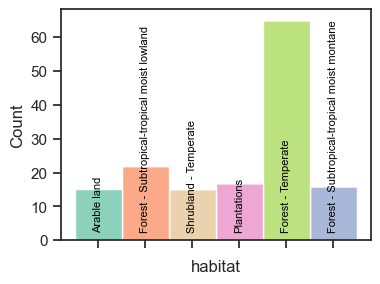

In [58]:
# Read the csv file with the data used for the correlation
from curses.ascii import FS


df = pd.read_csv(os.path.join(
                            CONFIG['save_dir'], 
                            csv_filename),
                            sep=',')

# print the number of aggregated samples 
print(f'The number of aggregated samples is {df.shape[0]}')

""" ==========================================================
    remove habitat with count less than 5 Sampling effort
=============================================================="""
# save initial dataframe
df_initial = df.copy()

# remove habitat with less than 5 aggregated samples
df = df.groupby('habitat').filter(lambda x: len(x) >= 5)

# list of sites that were removed from the dataset df
removed_sites = df_initial[~df_initial.index.isin(df.index)]["site"]

# print the number of sites after removing the habitats with less than 5 aggregated samples
print(f'The number of sites after removing the habitats with less than 5 aggregated samples is {df.shape[0]}')
# print the sites that are removed from the dataset df
print(f'The sites that were removed are {removed_sites.values}')

""" ==========================================================
    Display the number of samples per habitat
=============================================================="""

# plot the density of files for each habitat
fig, ax = plt.subplots(figsize=(4,3))
# display the histogram of the count per habitat and set the legend outside the plot
sns.histplot(df, x='habitat', hue='habitat', multiple='stack', palette=HABITAT_COLOR, ax=ax, legend=False)
# no xtick label
ax.set_xticklabels([])
# add the habitat in each vertical bar of the histogram
# change the police of the text to 8
for i, v in enumerate(df['habitat'].unique()):
    ax.text(i, 3, str(v), color='black', ha='center', fontsize= 8, rotation=90)

plt.show()


## 4. Regression with linear regression tools



How to interpret negative R² => mostly due to domain matching

https://towardsdatascience.com/explaining-negative-r-squared-17894ca26321

> While we can use any arbitrary model to generate the predictions for scoring, we need to realize that the aforementioned equality is defined for models trained on the same data. Therefore, it doesn’t necessarily hold true when we use test data to evaluate models built on train data! There is no guarantee that the differences between a foreign model’s predictions and the data is smaller than the variation within the data itself.

> To summarize, we should expect R² to be bounded between zero and one only if a linear regression model is fit, and it is evaluated on the same data it is fitted on. Else, the definition of R² can lead to negative values.
> For this reason, MAE and RMSE are more informative. CCC (concordance correlation coefficient) is also a good metric to  evaluate the precision and agreement between predicted and observed values


### 4.1 Select and init the regressor

In [59]:
"""==============================================================================
    Regressor selection
    -------------------

    The choice of regressor is crucial for the success of the model. 
    We choose to use the Huber Regressor as it is robust to outliers.
    We will estimate the slope and intercept of the model using a GroupKFold 
    cross-validation where the groups are the habitats. 
    This way, we ensure that the model is not biased by the habitat and that 
    it can generalize to new habitats.

=============================================================================="""

# https://scikit-learn.org/stable/auto_examples/linear_model/plot_robust_fit.html#sphx-glr-auto-examples-linear-model-plot-robust-fit-py
# Best Regressor when outliers are present in x and y
model = HuberRegressor(max_iter=100, alpha=0.0001, epsilon=1.20, fit_intercept=True, warm_start=False, tol=1e-05)


### 4.2 With a single indice

In [60]:
"""==============================================================================
    Do the kfold regression
    ------------------------

    Group k-fold is a variation of k-fold which ensures that the same group is not
    represented in both testing and training sets. 

    Interpretation of the scores
    ----------------------------
    CCC           => CCC is close to 1 when variables are very similar
    CCC_L_SHIFT   => the shift location of equivalent variables is close to 0
    CCC_S_SHIFT   => The scale shift of equivalent variables is close to 1
    CCC_BIAS      => bias correction factor measures the deviation of the regression line of the variables from the line with equation y=x. It is close to 1 when there is no deviation.
    ME            => ME close to 0 means no biais
    MAE           => MAE close to 0 means no error
    RMSE          => RMSE close to 0 means no error
    R2            => R2 close to 1 means that the model explains all the variance (only true when the train and test data are from the same distribution)
    MEDIAN_AE     => MEDIAN_AE close to 0 means no error
    pvalue        => pvalue < 0.05 means that the model is significant

    Summary of the steps:
    ---------------------
    - For each indice in the list of indices:
        - Perform a GroupKFold regression using the indice as predictor and the ground truth as target
        - Store the metrics for each indice in a dataframe (df_metrics_kfold)
        - Store the best model for each indice in a dictionnary
    - Filter the dataframe (df_metrics_kfold) to keep only the rows with pvalue < 0.05
    - Sort the dataframe (df_metrics_kfold) by R2
    - Display the dataframe (df_metrics_kfold)
================================================================================"""

# Compute the metrics for each indice in order to find the best indice

# do not show the error in this cell
warnings.filterwarnings('ignore')

df_metrics_kfold = pd.DataFrame(columns=[
                                'INDICE', 
                                'CCC', 'CCC_L_SHIFT', 'CCC_S_SHIFT', 'CCC_BIAS', 
                                'ME',
                                'MAE', 'RMSE', 'R2', 'MEDIAN_AE', 
                                'pvalue'])

best_models_kfolds = {}

# Do Group Kfold Regression
for CURRENT_INDICE in CONFIG['list_indices'] :
    current_df_metrics_kfold, current_model_list = groupkfold_regression(
                                                        indices=[CURRENT_INDICE],
                                                        gt=GT,
                                                        df=df,
                                                        model=model,
                                                        seed = CONFIG['seed'],
                                                        verbose=False, 
                                                        )
    

    # concatenate the dataframe
    df_metrics_kfold = pd.concat([df_metrics_kfold, current_df_metrics_kfold], axis=0, ignore_index=True) 

    # add model to the dictionnary for the current indice
    best_models_kfolds.update(current_model_list[0])


# do not show the error in this cell
warnings.filterwarnings('default')

# filter the dataframe to keep only the rows with pvalue < 0.05
# df_metrics_kfold = df_metrics_kfold[df_metrics_kfold['pvalue'] < 0.05]

# sort the dataframe by R_CCC_train
df_metrics_kfold.sort_values(['CCC'], ascending=False, inplace=True)

# display the dataframe
pd.options.display.float_format = "{:,.2f}".format # display numbers with 2 decimals
display(df_metrics_kfold)



/home/haupert/miniconda3/envs/ear-ml/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/haupert/miniconda3/envs/ear-ml/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1725520/998402493.py:422: RuntimeWarning: divide by zero encountered in scalar divide
/home/haupert/miniconda3/envs/ear-ml/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/haupert/miniconda3/envs/ear-ml/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1725520/998402493.py:422: RuntimeWarning: divide by zero encountered in scalar divide
/home/haupert/miniconda3/envs/ear-ml/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: Run

,INDICE,CCC,CCC_L_SHIFT,CCC_S_SHIFT,CCC_BIAS,ME,MAE,RMSE,R2,MEDIAN_AE,pvalue
58,nROI,0.42,-0.13,0.68,0.64,0.07,1.06,1.25,-0.58,0.96,0.01
49,EVNspCount,0.35,-0.42,0.77,0.71,0.14,1.12,1.34,-1.31,0.99,0.01
59,aROI,0.35,-0.85,0.62,0.52,0.40,1.22,1.42,-1.81,1.16,0.01
20,NP,0.35,-0.45,0.73,0.61,0.02,1.30,1.55,-3.30,1.20,0.01
47,EVNspFract,0.34,-0.61,0.71,0.65,0.25,1.18,1.40,-1.92,1.09,0.01
42,MFC,0.32,-0.64,0.67,0.59,0.30,1.19,1.40,-1.60,1.15,0.01
45,ACTspCount,0.32,-0.56,0.77,0.67,0.17,1.21,1.45,-2.05,1.07,0.01
44,ACTspFract,0.32,-0.56,0.77,0.67,0.17,1.21,1.45,-2.06,1.07,0.01
46,ACTspMean,0.26,-0.48,0.69,0.61,0.20,1.17,1.46,-1.49,1.00,0.01
37,BIO,0.25,-0.73,0.57,0.44,0.19,1.53,1.70,-4.32,1.47,0.01


In [61]:
"""==============================================================================
    Compute the metrics of the best model for each indice
    -----------------------------------------------------

    The metrics are computed on the whole dataset, including the samples that were
    not used for the training of the model.

    Summary of the steps:
    ---------------------
    - For each indice in the list of significant indices (pvalue < 0.05):
        - Get the prediction from the best model
        - Compute the metrics (R2, MAE, RMSE, BIAS, SE, p-value)
        - Store the metrics in a dataframe (df_metrics)
    - Sort the dataframe (df_metrics) by R2
    - Display the dataframe (df_metrics)

================================================================================"""

# sort the column habitat to have the same automatic color assignation
df = df.sort_values(by='habitat')

# list of indices that have a significant p-value after group kfold regression 
significant_indices = df_metrics_kfold['INDICE'].tolist()

df_metrics = pd.DataFrame()

for CURRENT_INDICE in significant_indices :

    # Set the variables
    x = df_initial[CURRENT_INDICE].values
    y = df_initial[GT].values

    # Get the prediction from the best model
    slope = best_models_kfolds[CURRENT_INDICE].coef_[0]
    intercept = best_models_kfolds[CURRENT_INDICE].intercept_
    y_model = slope*x + intercept

    # Statistics
    n     = len(y)                                     # number of observations
    k     = 1                                          # number of independent variables
    dof   = n - k -1                                   # degrees of freedom (-1 for intercept)
    t     = stats.t.ppf(0.95, dof)                     # t-statistic; used for CI and PI bands

    # Estimates of Error in Data/Model
    residual = y - y_model                                          # residuals; diff. actual data from predicted values
    RSE     = np.sqrt(np.sum(residual**2) / dof)                    # standard error of the regression RSE also known as the standard error of the estimate
    SE      = np.sqrt(RSE**2 / (np.sum((x - np.mean(x))**2)))       # standard error SE of the slope
    r2    = 1-np.sum(residual**2) / np.sum((y - np.mean(y))**2)     # coefficient of determination r²
    mae   = np.mean(np.abs(residual))                               # mean absolute error (MAE)
    rmse  = np.sqrt(np.mean(residual**2))                           # root mean square error (RMSE)   
    bias  = np.mean(residual)                                       # estimate the bias (= mean error (ME))
    p_value = 2*(stats.t.sf(np.abs(slope) / SE, df=dof))            # p-value of the slope based on the estimator and the standard error (t-distribution)
    ccc     = ccc_est(y, y_model)                                   # concordance correlation coefficient (CCC)

    # add the metrics to the dataframe
    if df_metrics.empty :
        df_metrics = pd.DataFrame({'INDICE': [CURRENT_INDICE], 'R2': [r2], 'CCC': [ccc], 'MAE': [mae], 'RMSE': [rmse], 'BIAS': [bias], 'p-value': [p_value]})
    else :
        df_metrics = pd.concat([df_metrics, pd.DataFrame({'INDICE': [CURRENT_INDICE], 'R2': [r2], 'CCC': [ccc], 'MAE': [mae], 'RMSE': [rmse], 'BIAS': [bias], 'p-value': [p_value]})], ignore_index=True)

# sort the dataframe by R2
df_metrics.sort_values(['R2'], ascending=False, inplace=True)

# Display the modified DataFrame
df_metrics = df_metrics.round(2)
display(df_metrics)

# number of indices with p-value < 0.05
print(f'Number of indices with p-value < 0.05: {len(df_metrics[df_metrics["R2"] > 0.25])}')



/home/haupert/miniconda3/envs/ear-ml/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/haupert/miniconda3/envs/ear-ml/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1725520/998402493.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  u = (yb - xb) / ((sx2 * sy2) ** 0.25)


,INDICE,R2,CCC,MAE,RMSE,BIAS,p-value
0,nROI,0.60,0.79,0.85,1.13,-0.18,0.00
1,EVNspCount,0.57,0.74,0.93,1.18,0.07,0.00
7,ACTspFract,0.50,0.68,1.01,1.27,0.10,0.00
6,ACTspCount,0.50,0.68,1.01,1.27,0.10,0.00
4,EVNspFract,0.50,0.69,1.04,1.27,-0.33,0.00
5,MFC,0.48,0.72,1.04,1.30,-0.32,0.00
2,aROI,0.40,0.68,1.11,1.39,-0.50,0.00
9,BIO,0.35,0.50,1.22,1.45,-0.35,0.00
10,LFC,0.34,0.56,1.13,1.46,-0.31,0.00
14,EAS,0.34,0.52,1.16,1.46,-0.29,0.00


Number of indices with p-value < 0.05: 14


The slope of the best model is [0.02498409]
The intercept of the best model is 1.014312552781216

Shapiro-Wilk Test for Normality of Residuals
Statistics=0.985, p=0.092
Known dataset: Residual looks Gaussian (fail to reject H0)


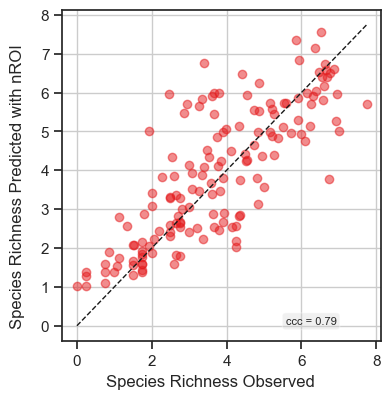

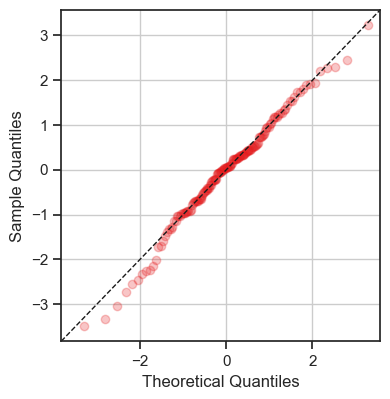

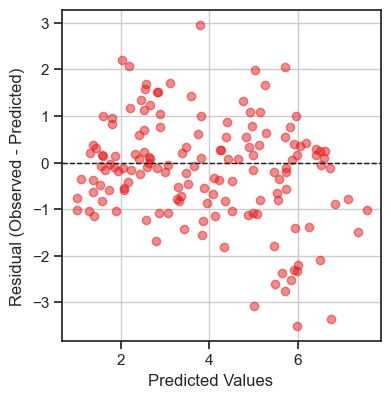

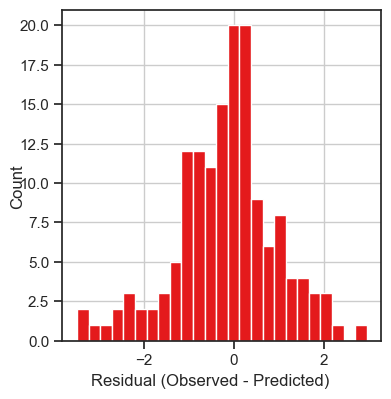

In [62]:
"""==============================================================================
        Plot the prediction vs the test and the residuals for the best model
        --------------------------------------------------------------------

        Summary of the steps:
        ---------------------
        - Get x and y from the dataframe used for the training and corresponding 
        to the indice (INDICE). Habitats with less than 3 replicates have been removed.
        - Get the best model corresponding to the indice
        - Get the prediction y_pred from the best model of this indice
        - Compute the Concordance Correlation Coefficient (CCC) between y and y_pred
        - Plot the sanity check plots:
                - Scatter plot of y vs y_pred with the metric on the plot
                - QQ plot of the residuals
                - Residuals vs prediction
                - Histogram of the residuals 
        - Test the normality of the residuals with shapiro test   

=============================================================================="""

SELECTED_INDICE = 'nROI' # nROI EVNspCount ACTspFract MFC NP EAS aROI BIO TFSD

# concatenate the list CONFIG['list_indices'] to a string
INDICE_STR = '_'.join([SELECTED_INDICE])

# with known dataset
x = df[SELECTED_INDICE].to_numpy().reshape(-1,1)
y = df[GT].astype('float')

# find the best model corresponding to the indice
best_model = best_models_kfolds[SELECTED_INDICE] 

# print the coefficient of the best model
print(f'The slope of the best model is {best_model.coef_}')
print(f'The intercept of the best model is {best_model.intercept_}')

# do the prediction
y_pred = best_model.predict(x)

# extract CCC from the dataframe (sometimes it's None when the fit is not possible)
# the metric corresponds to the average CCC obtained during the kfold cross-validation
ccc = ccc_est(y, y_pred)

plot_datasets(
        y, 
        y_pred, 
        metric=ccc,
        xlabel='Species Richness Observed',
        ylabel='Species Richness Predicted with '+ ' '.join([SELECTED_INDICE]),
        color=RED,
        plot_qqplot=True,
        plot_residuals=True,
        plot_residuals_distribution=True)

# Test the normality of the residuals with shapiro test
# shapiro test
stat, p = stats.shapiro(y-y_pred)
print('\nShapiro-Wilk Test for Normality of Residuals')
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
        print('Known dataset: Residual looks Gaussian (fail to reject H0)')
else:
        print('Known dataset: Residual does not look Gaussian (reject H0)')

if SAVE_RESIDUALS :
        df_residuals = pd.DataFrame({
                                'site': df_initial['site'],
                                'residual': y - y_pred
                                })
        df_residuals.to_csv(path_or_buf=os.path.join(CONFIG['save_dir'], SELECTED_INDICE+'_residuals_simple_regression.csv'), sep=',', mode='w', header=True, index=True)
        

In [47]:
"""==============================================================================
    Compute spatially corrected standard errors for the best model
    -------------------------------------------------------------
    Summary of the steps:
    ---------------------
    - Read the csv file with the coordinates of the sites
    - Merge the coordinates with the initial dataframe (df_initial) to keep only the sites present in df_initial
    - Set the variables X and y
    - Extract the weights and residuals from the Huber model
    - Calculate the 'Bread' (X' W X)^-1
    - Calculate the 'Meat' (Spatial Correlation)
    - Calculate the Sandwich
    - Calculate the standard errors, t-statistics and p-values
    - Display the results table

================================================================================"""

from scipy.spatial.distance import pdist, squareform
cutoff=1.0

# read csv file with coordinates
coords = pd.read_csv(os.path.join(
                            CONFIG['save_dir'], 
                            "train_dataset_for_statistical_modeling_in_R.csv"),
                            sep=',')

# group by site and get the first occurrence of latitude and longitude and keep only site, latitude and longitude columns
coords = coords.groupby('site').first().reset_index()
coords = coords[['site', 'LAT', 'LON']]

# merge coords with df_initial to keep only the sites present in df_initial
df_initial_with_coords = pd.merge(df_initial, coords, on='site', how='left')

# Set the variables
X = df_initial_with_coords[SELECTED_INDICE].to_numpy().reshape(-1,1)
y = df_initial_with_coords[GT].to_numpy()
huber = best_models_kfolds[SELECTED_INDICE]

# Add intercept for matrix math
X_inc = np.column_stack([np.ones(n), X])
beta = np.array([huber.intercept_, *huber.coef_])

# 2. Extract Weights and Residuals
# Huber weights: 1 for inliers, (epsilon*sigma)/|resid| for outliers
resid = y - huber.predict(X)
sigma = huber.scale_
eps = huber.epsilon
abs_resid_norm = np.abs(resid) / sigma
weights = np.where(abs_resid_norm <= eps, 1.0, eps / abs_resid_norm)

# 3. Calculate the 'Bread' (X' W X)^-1
# Note: Huber is an M-estimator; we use the weighted design matrix
XW = X_inc * weights[:, np.newaxis]
bread = np.linalg.inv(X_inc.T @ XW)

# 4. Calculate the 'Meat' (Spatial Correlation)
# scores_i = weight_i * resid_i * x_i
scores = (weights * resid)[:, np.newaxis] * X_inc

# Distance matrix and Kernel (Bartlett/Triangular)
dist_mat = squareform(pdist(df_initial_with_coords[['LAT', 'LON']].to_numpy(), metric='euclidean'))
kernel = np.maximum(0, 1 - dist_mat / cutoff)

# Meat = sum_i sum_j (score_i * score_j' * kernel_ij)
meat = scores.T @ kernel @ scores

# 5. The Sandwich
vcov = bread @ meat @ bread
se = np.sqrt(np.diag(vcov))

# 6. Results Table
t_stats = beta / se
p_vals = 2 * (1 - stats.norm.cdf(np.abs(t_stats)))

pd.DataFrame({
    'Feature': ['Intercept'] + [f'X{i}' for i in range(X.shape[1])],
    'Coef': beta,
    'Spatial_SE': se,
    'p_value': p_vals})

'==============================================================================\n    Compute spatially corrected standard errors for the best model\n================================================================================'

R² is 0.60
MAE is 0.85
RMSE is 1.13
Bias is -0.18
Standard error of the regression RSE is 1.142162
The slope of the best model is 0.025 with a standard error of 0.001
p-value for the slope  is 3.09e-40
p-value for the intercept  is 1.19e-07
Uncertainty of the slope is 0.002
The intercept of the best model is 1.014 with a standard error of 0.302
Uncertainty of the intercept is 0.302
prediction interval is  1.9047074590915432


/tmp/ipykernel_1725520/3259033695.py:119: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter([], [], c=HABITAT_COLOR[habitat], label=habitat, marker='s', s=40)


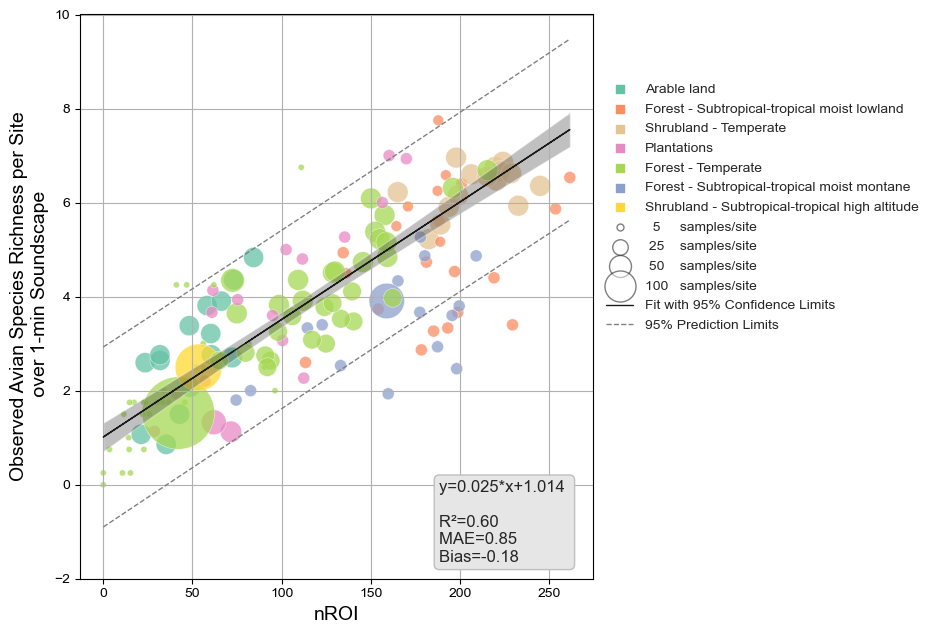

In [48]:
"""==============================================================================
      Display the correlation between the indice and the ground truth
      as well as the model curve and the confidence and prediction intervals
      ---------------------------------------------------------------

      The initial dataset including the samples that were
      not used for the training of the model is used for this plot.
      
      Summary of the steps:
      ---------------------
      - Get x and y from the initial dataframe with all the samples. Select only the data 
      corresponding to the indice (INDICE)
      - Get the best model corresponding to the indice
      - Get the prediction y_model from the best model of this indice
      - Compute the metrics (R2, MAE, RMSE, BIAS, SE, p-value)
      - Plot the correlation between the indice and the ground truth with 
      the metrics on the plot

================================================================================"""

#------------------------------------------------------------
# Compute the metrics of the best model for the indice
#------------------------------------------------------------

# Set the variables
x = df_initial[SELECTED_INDICE].values
y = df_initial[GT].values

# Get the prediction from the best model
slope = best_models_kfolds[SELECTED_INDICE].coef_[0]
intercept = best_models_kfolds[SELECTED_INDICE].intercept_
y_model = slope*x + intercept

# Statistics
n     = len(y)                                     # number of observations
k     = 1                                          # number of independent variables
dof   = n - k -1                                   # degrees of freedom (-1 for intercept)
t     = stats.t.ppf(0.95, dof)                     # t-statistic; used for CI and PI bands

# Estimates of Error in Data/Model
residual = y - y_model                                          # residuals; diff. actual data from predicted values
RSE     = np.sqrt(np.sum(residual**2) / dof)                    # standard error of the regression RSE also known as the standard error of the estimate
SE      = np.sqrt(RSE**2 / (np.sum((x - np.mean(x))**2)))       # standard error SE of the slope
SE_intercept = SE * np.sqrt(np.sum(x**2) / n)                   # standard error SE of the intercept
r2    = 1-np.sum(residual**2) / np.sum((y - np.mean(y))**2)     # coefficient of determination r²
mae   = np.mean(np.abs(residual))                               # mean absolute error (MAE)
rmse  = np.sqrt(np.mean(residual**2))                           # root mean square error (RMSE)   
bias  = np.mean(residual)                                       # estimate the bias (= mean error (ME))
p_value = 2*(stats.t.sf(np.abs(slope) / SE, df=dof))            # p-value of the slope based on the estimator and the standard error (t-distribution)
p_value_intercept = 2*(stats.t.sf(np.abs(intercept) / SE_intercept, df=dof))            # p-value of the slope based on the estimator and the standard error (t-distribution)

# Uncertainty of the slope
slope_uncertainty = SE * t

# uncertainty of the intercept
intercept_uncertainty = SE_intercept * t 

# Print the results
print(f'R² is {r2:.2f}')
print(f'MAE is {mae:.2f}')
print(f'RMSE is {rmse:.2f}')
print(f'Bias is {bias:.2f}')
print(f'Standard error of the regression RSE is {RSE:.6f}')
# print the coefficient of the best model (with 3 decimals)
print(f'The slope of the best model is {slope:.3f} with a standard error of {SE:.3f}')
print(f'p-value for the slope  is {p_value:.2e}')
print(f'p-value for the intercept  is {p_value_intercept:.2e}')
print(f'Uncertainty of the slope is {slope_uncertainty:.3f}')
print(f'The intercept of the best model is {intercept:.3f} with a standard error of {SE * t * np.sqrt(np.sum(x**2) / n):.3f}')
print(f'Uncertainty of the intercept is {intercept_uncertainty:.3f}')

#----------------------------------------------------------------
# Display the correlation between the indice and the ground truth
#----------------------------------------------------------------

# Display the correlation graphic between the indice and the ground truth
fig, ax1 = plt.subplots(1, 1)
ax1.grid()

# marker size
# extact the column count from df_initial, and multiply the values (scalar) by 5
marker_size = df_initial['count'].values*5

# display the scatterplot
sns.set_theme(style="whitegrid")
sns.set_style("ticks")
sns.scatterplot(data=df_initial, x=SELECTED_INDICE, y=GT, hue='habitat', palette=HABITAT_COLOR, alpha=0.75, s=marker_size, ax=ax1, legend=False)

# change y axis label
ax1.set_ylabel('Observed Avian Species Richness per Site\n over 1-min Soundscape', size=14)

# change x axis label
ax1.set_xlabel(SELECTED_INDICE, size=14)

# # set the y limit
ax1.set_ylim(-2, 10)

# add metrics on the graph
if p_value >= 1e-16 :
      pvalue_str = 'p=%.2e' % p_value
else:
      pvalue_str = 'p<1e-16'

ax1.annotate(
      # "R²=%.2f \nMAE=%.2f \nBias=%.2f \n%s" % (r2, mae, bias, pvalue_str),     
      "y=%.3f*x+%0.3f \n\nR²=%.2f \nMAE=%.2f \nBias=%.2f " % (slope, intercept, r2, mae, bias),     
      xy=(0.7, 0.1), 
      xycoords='axes fraction', 
      ha='left', 
      va='center', 
      bbox=dict(
            facecolor="0.9", 
            edgecolor='0.75', 
            boxstyle='round')
      )

# add a legend with fixed marker size for each habitat and its corresponding color
for habitat in df_initial['habitat'].unique():
      ax1.scatter([], [], c=HABITAT_COLOR[habitat], label=habitat, marker='s', s=40)

# add bubble size legend
if 'species_richness_by_site_and_day' in csv_filename:
      bubble_sizes = [5, 15, 30, 60, 0]
      bubble_labels = [' 5     samples/day/site', '15    samples/day/site', '30    samples/day/site', '60    samples/day/site', '  ']
      for size, label in zip(bubble_sizes, bubble_labels):
            ax1.scatter([], [], c='white', edgecolor='black', alpha=0.5, s=size*5, label=label)
elif 'species_richness_by_site' in csv_filename:
      bubble_sizes = [5, 25, 50, 100]
      bubble_labels = ['  5     samples/site', ' 25    samples/site', ' 50    samples/site', '100   samples/site']
      for size, label in zip(bubble_sizes, bubble_labels):
            ax1.scatter([], [], c='white', edgecolor='black', alpha=0.5, s=size*5, label=label)

# plot the line of best fit
ax1.plot(x, y_model, "-", color='0.1', linewidth=1, alpha=1, label="Fit with 95% Confidence Limits")  

# Confidence Interval
x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = slope*x2 + intercept

# plot the confidence interval and the prediction interval on the graph
_, ci, pi = plot_pi_ci_manual(t, RSE, n, x, x2, y2, ax=ax1)
print("prediction interval is ", np.mean(pi))

# Move the legend to the bottom
ax1.legend(title="habitat", loc="upper left", fontsize=8)
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 0.9), ncol=1, title=None, frameon=False, fontsize=10)

# Set figure size
fig.set_size_inches((9.5,6.5))
fig.tight_layout()

if SELECTED_INDICE == 'nROI' :
      # test if csv_filename contains species_richness_by_site_and_day
      if 'species_richness_by_site' in csv_filename :
            if SAVE : fig.savefig(os.path.join(CONFIG['save_dir'], 'figure_1c_onlybirds.png'), dpi = 300, bbox_inches = "tight")
if SELECTED_INDICE == 'EVNspCount' :
      if SAVE : fig.savefig(os.path.join(CONFIG['save_dir'], 'figure_4a_onlybirds.png'), dpi = 300, bbox_inches = "tight")
if SELECTED_INDICE == 'ACTspFract' :
      if SAVE : fig.savefig(os.path.join(CONFIG['save_dir'], 'figure_4b_onlybirds.png'), dpi = 300, bbox_inches = "tight")

### 4.4 Regresssion with multiple indices

In [49]:
"""===============================================================================
    Remove indices that are not used in the multiple regression
    ----------------------------------------------------------

    The multiple regression is done with the indices that have a significant correlation 
    with species richness and that are not highly correlated with other selected indices
    to avoid multicollinearity issues.
    The indices that are not used in the multiple regression are removed from the list of indices 
    (CONFIG['list_indices']). The list of indices that are used in the multiple regression
    is defined in the configuration file (CONFIG['list_indices_multiple_regression']).

    Summary of the steps:
    ---------------------
    - Get the list of indices that are used in the multiple regression from the 
    configuration file (CONFIG['list_indices_multiple_regression'])
    - Remove the indices that are not in this list from the list of indices 
    (CONFIG['list_indices'])
    - Print the list of indices that are used in the multiple regression
    - Print the list of indices that are removed from the list of indices
================================================================================"""

# list of indices for the regresssion with multiple indices
list_indices_multiple_regression = CONFIG['list_indices_multiple_regression']

# remove list_indices_to_remove in CONFIG['list_indices']
list_indices_to_remove= [x for x in CONFIG['list_indices'] if x not in list_indices_multiple_regression]

# print the list of indices
print(list_indices_multiple_regression)
print(list_indices_to_remove)

['BioEnergy', 'NDSI', 'nROI', 'MFC', 'NP', 'EAS', 'LFC', 'ACI', 'TFSD']
['ZCR', 'MEANt', 'VARt', 'SKEWt', 'KURTt', 'LEQt', 'BGNt', 'SNRt', 'M', 'Ht', 'ACTtFraction', 'ACTtCount', 'ACTtMean', 'EVNtFraction', 'EVNtMean', 'EVNtCount', 'MEANf', 'VARf', 'SKEWf', 'KURTf', 'LEQf', 'BGNf', 'SNRf', 'Hf', 'H', 'ECU', 'ECV', 'EPS', 'EPS_KURT', 'EPS_SKEW', 'rBA', 'AnthroEnergy', 'BIO', 'ROU', 'ADI', 'AEI', 'HFC', 'ACTspFract', 'ACTspCount', 'ACTspMean', 'EVNspFract', 'EVNspMean', 'EVNspCount', 'H_Havrda', 'H_Renyi', 'H_pairedShannon', 'H_gamma', 'H_GiniSimpson', 'RAOQ', 'AGI', 'aROI']


In [50]:
"""==============================================================================
    Do the kfold regression with multiple indices
    ---------------------------------------------

    This time the regression is done with multiple indices as predictors.

    Group k-fold is a variation of k-fold which ensures that the same group is not
    represented in both testing and training sets. Here the groups are the habitats.

    Interpretation of the scores
    ----------------------------
    CCC           => CCC is close to 1 when variables are very similar
    CCC_L_SHIFT   => the shift location of equivalent variables is close to 0
    CCC_S_SHIFT   => The scale shift of equivalent variables is close to 1
    CCC_BIAS      => bias correction factor measures the deviation of the regression line of the variables 
                    from the line with equation y=x. It is close to 1 when there is no deviation.
    ME            => ME close to 0 means no biais
    MAE           => MAE close to 0 means no error
    RMSE          => RMSE close to 0 means no error
    R2            => R2 close to 1 means that the model explains all the variance 
                    (only true when the train and test data are from the same distribution)
    MEDIAN_AE     => MEDIAN_AE close to 0 means no error
    pvalue        => pvalue < 0.05 means that the model is significant

    Summary of the steps:
    ---------------------
    - Perform a GroupKFold regression using the list of indices for multiple regression 
    as predictors and the ground truth as target
    - Store the metrics in a dataframe (df_metrics_kfold) and the best model in a dictionnary
================================================================================"""


# do not show the error in this cell
warnings.filterwarnings("ignore")

# Normalize the data as now there are than a single indice
df_scaled = df.copy()
scaler = StandardScaler()
df_scaled[list_indices_multiple_regression + [GT]] = scaler.fit_transform(df_scaled[list_indices_multiple_regression + [GT]])

df_metrics_kfold, models_list = groupkfold_regression(
                                indices=list_indices_multiple_regression,
                                gt=GT,
                                df=df_scaled,
                                model=model,
                                seed = CONFIG['seed'],
                                verbose=True,
                            )   

warnings.filterwarnings('default')


The groups are [0 1 2 3 4 5]
CCC=0.36 CCC_L_SHIFT=-0.15 CCC_S_SHIFT=0.89 CCC_BIAS=0.79 ME0.15 MAE=0.61 RMSE=0.84 R2=-0.66 MEDIAN_AE=0.49 P-value=0.009900990099009901


/home/haupert/miniconda3/envs/ear-ml/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but HuberRegressor was fitted without feature names
  warnings.warn(



Shapiro-Wilk Test for Normality of Residuals
Statistics=0.985, p=0.094
Known dataset: Residual looks Gaussian (fail to reject H0)


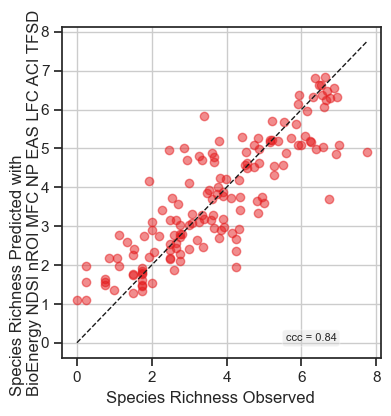

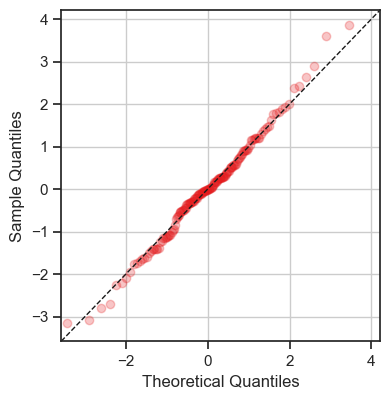

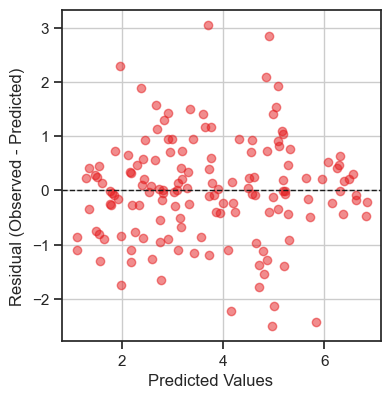

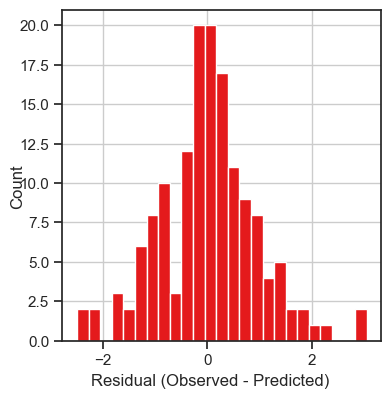

In [54]:
"""==============================================================================
        Plot the prediction vs the test and the residuals for the best model
        --------------------------------------------------------------------

        Multiple regression with the indices in list_indices_multiple_regression

        Summary of the steps:
        ---------------------
        - Get x and y from the dataframe used for the training and corresponding 
        to the list of indices. Habitats with less than 3 replicates have been removed.
        - Get the best model found using multiple indices
        - Get the prediction y_pred from the best model found using multiple indices
        - Compute the Concordance Correlation Coefficient (CCC) between y and y_pred
        - Plot the sanity check plots:
                - Scatter plot of y vs y_pred with the metric on the plot
                - QQ plot of the residuals
                - Residuals vs prediction
                - Histogram of the residuals 
        - Test the normality of the residuals with shapiro test   

=============================================================================="""

# concatenate the list CONFIG['list_indices'] to a string
INDICE_STR = '_'.join(list_indices_multiple_regression)

# with known dataset
x = df_scaled[list_indices_multiple_regression].astype('float')
y = df_scaled[GT].astype('float')

# find the first value of the dictionnary models_list
best_model_multireg = models_list[0]
# get the key of the dictionnary
indice = list(best_model_multireg.keys())[0]  
# get the value of the dictionnary
best_model_multireg = best_model_multireg[indice]

# do the prediction
y_pred = best_model_multireg.predict(x[list_indices_multiple_regression])

# inverse normalize
x[GT] = y
y = scaler.inverse_transform(x)[:,-1]
x[GT] = y_pred
y_pred = scaler.inverse_transform(x)[:,-1]

# metric
ccc = ccc_est(y, y_pred)                    # concordance correlation coefficient (CCC)

# plot the sanity check plots
plot_datasets(
        y, 
        y_pred, 
        metric=ccc,
        xlabel='Species Richness Observed',
        ylabel='Species Richness Predicted with \n'+ ' '.join(list_indices_multiple_regression),
        color=RED,
        plot_qqplot=True,
        plot_residuals=True,
        plot_residuals_distribution=True)

# Test the normality of the residuals with shapiro test
# shapiro test
stat, p = stats.shapiro(y-y_pred)
print('\nShapiro-Wilk Test for Normality of Residuals')
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
        print('Known dataset: Residual looks Gaussian (fail to reject H0)')
else:
        print('Known dataset: Residual does not look Gaussian (reject H0)')


#### 4.4.2 Metrics

In [28]:
"""==============================================================================
      Estimate the metrics of the best model with multiple indices
      ---------------------------------------------------------------

      The initial dataset including the samples that were
      not used for the training of the model is used for this plot.

      Summary of the steps:
      ---------------------
      - Get x and y from the initial dataframe with all the samples. Select only the data
            corresponding to the list of indices
      - Get the best model corresponding to the list of indices
      - Get the prediction y_model from the best model of this list of indices
      - Compute the metrics (R2, MAE, RMSE, BIAS, SE, p-value)
      - Plot the correlation between the indice and the ground truth with
            the metrics on the plot
================================================================================"""

###### Statistics to estimate the error in the data/model
# sort the column habitat to have the same automatic color assignation
df_initial.sort_values(by='habitat')

# scale the initial dataframe with the scaler used for the kfold regression
# and set the variables
x = scaler.transform(df_initial[list_indices_multiple_regression + [GT]])[:,:-1]
y = scaler.transform(df_initial[list_indices_multiple_regression + [GT]])[:,-1]

# Get the prediction from the best model
y_model = np.sum((best_model_multireg.coef_)*x, axis=1) + best_model_multireg.intercept_

# Statistics
n              = len(y)                        # number of observations
k              = x.shape[1]                    # number of independent variables
dof_regression = k                             # degrees of freedom of the regression
dof_residual   = n - k -1                      # degrees of freedom of the residual (-1 for intercept)

# Estimates of Error in Data/Model
residual      = y - y_model                     # residuals; diff. actual data from predicted values

r2 = 1-np.sum(residual**2) / np.sum((y - np.mean(y))**2)  # calculate the coefficient of determination r²
mae = np.mean(np.abs(residual))                 # estimate the MAE      
bias = np.mean(residual)                        # estimate the bias (= mean error (ME))      
ccc = ccc_est(y, y_model)                    # concordance correlation coefficient (CCC)


# Step 1: Calculate sums of squares
SST = np.sum((y - np.mean(y))**2)               # Total Sum of Squares
SSR = np.sum((y_model - np.mean(y))**2)         # Regression Sum of Squares     
SSE = np.sum((y - y_model)**2)                  # Error Sum of Squares (Residual Sum of Squares)

# Step 2: Calculate Mean Squares and F-statistic
MSR = SSR / dof_regression                      #  Mean Square Regression
MSE = SSE / dof_residual                        #  Mean Square Error (Residual)
F_statistic = MSR / MSE

# Step 3: Calculate p-value from F-statistic
p_value = stats.f.sf(F_statistic, dof_regression, dof_residual)

# Print the results
print(f'r² is {r2:.2f}')
print(f'mae is {mae:.2f}')
print(f'bias is {bias:.2f}')
print(f'ccc is {ccc:.2f}')

print(f"Overall F-statistic: {F_statistic:.4f}")
print(f"Overall Model P-value: {p_value:.4f}")


r² is 0.72
mae is 0.39
bias is 0.01
ccc is 0.84
Overall F-statistic: 39.7209
Overall Model P-value: 0.0000


#### 4.4.3 Find coefficients importance



https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html

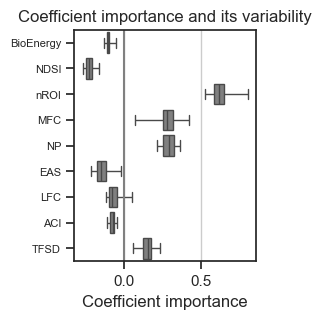

In [29]:
"""==============================================================================
        Estimate the coefficients of the best model with multiple indices
        ---------------------------------------------------------------
    
        The coefficients are estimated with a RepeatedKFold cross-validation
        on the filtered dataset excluding the samples that were
        not used for the training of the model.
    
        Summary of the steps:
        ---------------------
        - Get x and y from the scaled dataframe used for the training and corresponding 
        to the list of indices. Habitats with less than 3 replicates have been removed.
        - Get the best model found using multiple indices
        - Do a RepeatedKFold cross-validation to estimate the coefficients of the model
        - Store the coefficients in a dataframe (df_coef)   
================================================================================"""

# with known dataset
X_kfold = df_scaled[list_indices_multiple_regression].astype('float')
y_kfold = df_scaled[GT].astype('float')

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=CONFIG['seed'])
cv_model = cross_validate(
    best_model_multireg,
    X_kfold,
    y_kfold,
    cv=cv,
    return_estimator=True,
    n_jobs=-1,
)

# initialize an empty dataframe to store the coefficients of the model
coefs = np.empty((len(list_indices_multiple_regression)))

# for each estimator of the cross-validation, get the coefficients and multiply them by the standard deviation of the corresponding indice
for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X_kfold, y_kfold)) :
    coef_corrected = est.coef_ * X_kfold.iloc[train_idx].std(axis=0)
    # add the coefficients of the model to the dataframe
    coefs = np.vstack((coefs, coef_corrected))

# remove the first row
coefs = coefs[1:,:]

# create a dataframe with the coefficients of the model
df_coef = pd.DataFrame(coefs, columns=list_indices_multiple_regression)

# plot the coefficients of the model with a boxplot
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3,3)
fig.tight_layout()
ax.grid()
sns.boxplot(data=df_coef, orient="h", color="grey", saturation=0.1, whis=10)
# add grid
ax.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.yticks(fontsize=8)
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

/home/haupert/miniconda3/envs/ear-ml/lib/python3.10/site-packages/matplotlib/cbook.py:1699: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.isfinite(val)
/home/haupert/miniconda3/envs/ear-ml/lib/python3.10/site-packages/matplotlib/cbook.py:1699: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.isfinite(val)


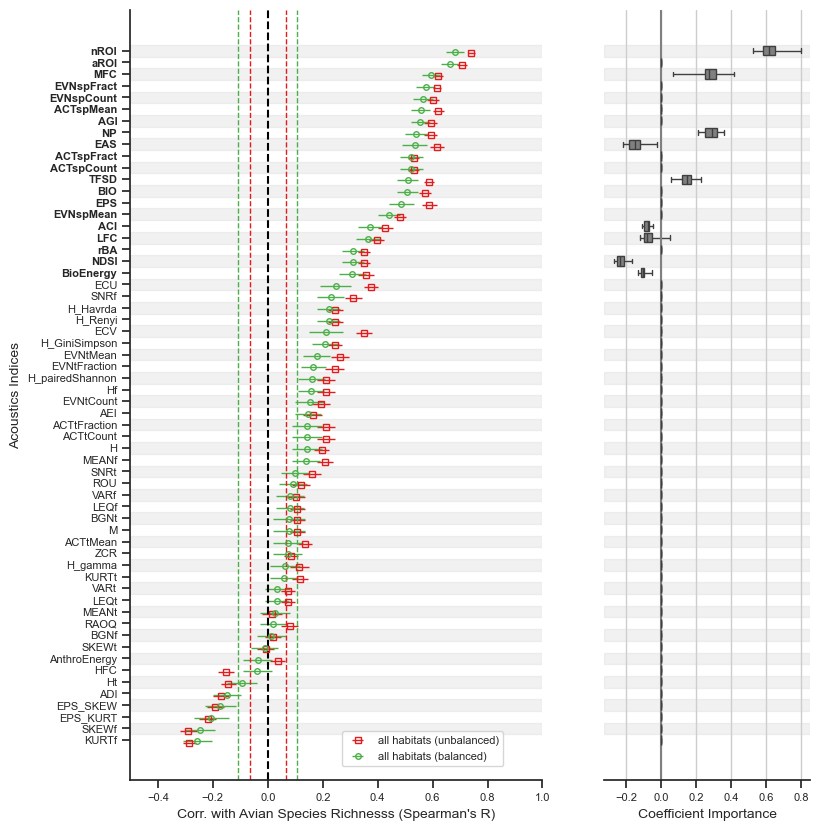

In [30]:
"""==============================================================================
    Plot the correlation between the indices and the ground truth
    --------------------------------------------------------------- 

    Combine the correlation results obtained with the balanced and unbalanced datasets
    and the coefficients importance of the multiple regression in a single plot.

    Summary of the steps:   
    ---------------------
    - Read the csv file with the correlation results
    - Sort the indices by the correlation obtained with the balanced dataset
    - Create a mapping between the indices and their corresponding number
    - Generate the labels and the y-axis values
    - Select the indices with a correlation higher than the threshold for each habitat and dataset
    - Plot the coefficient importance with error bars representing the confidence interval
================================================================================"""

#******************************************
# First part: correlation results
#******************************************

df_stat = pd.read_csv(os.path.join(CONFIG['save_dir'], GT+'_'+CONFIG['correlation_method']+"_r_sans_clip_onlybirds.csv"), sep=',', index_col=None)

# sort by r obtained with balanced dataset by habitats
sort_indices = df_stat[df_stat['habitat']=='all_balanced'].sort_values(by='r', ascending=False)['indice']

# Create an empty dictionary to store the mapping
indice_mapping = {}

# Iterate over the unique values of 'indice' and assign corresponding numbers
i = 0
for unique_indice in sort_indices:
    indice_mapping[unique_indice] = i
    i += 1

# Add the dictionary to the DataFrame
df_stat['indice_number'] = df_stat['indice'].map(indice_mapping)

# Generating labels and index
label = sort_indices
y = np.arange(len(label))

# select the indices with r > r_threshold for each habitat, dataset
df_all_balanced = df_stat[(df_stat['habitat']=='all_balanced')]
df_all_unbalanced = df_stat[(df_stat['habitat']=='all_unbalanced')]

# Apply the function to the 'list_column' and store the result in a new column
err_balanced = df_all_balanced['r'] - df_all_balanced['lower_bound_ci']
err_unbalanced =  df_all_unbalanced['r'] - df_all_unbalanced['lower_bound_ci']

sns.set_style("ticks")

# set 2 plots with shared y-axis but different size in x direction

fig, [ax1,ax2] = plt.subplots(1,2, width_ratios=(1,0.5), figsize=(8,10), sharey=True)

ax1.errorbar(x = df_all_unbalanced['r'], 
            y = df_all_unbalanced['indice_number'] + 0.2, 
            xerr=err_unbalanced, 
            label = 'all habitats (unbalanced)',
            marker='s', markersize = 4, markerfacecolor='none',
            linestyle="none", linewidth=1, color=RED, ecolor=RED)
ax1.errorbar(x = df_all_balanced['r'], 
            y = df_all_balanced['indice_number'] + 0.1, 
            xerr=err_balanced, 
            label = 'all habitats (balanced)',
            marker='o', markersize = 4, markerfacecolor='none',
            linestyle="none", linewidth=1, color=GREEN, ecolor=GREEN)

if format(CONFIG['correlation_method']) == 'pearson' :
    CORR_PLOT = 'Pearson'
elif format(CONFIG['correlation_method']) == 'spearman' :
    CORR_PLOT = 'Spearman'
elif format(CONFIG['correlation_method']) == 'kendall' :
    CORR_PLOT = 'Kendall'


ax1.set_xlabel('Corr. with Avian Species Richnesss ({}\'s R)'.format(CORR_PLOT), fontsize=10)
ax1.set_ylabel('Acoustics Indices', fontsize=10)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.tick_params(axis='both', labelsize=8)

# Draw a vertical line at 0
ax1.axvline(x=0, color='black', linestyle='dashed')
ax1.axvline(x=df_stat[df_stat['habitat']=='all_unbalanced']['r_threshold'].unique(), color=RED, linestyle='dashed',linewidth=1)
ax1.axvline(x=df_stat[df_stat['habitat']=='all_balanced']['r_threshold'].unique(), color=GREEN, linestyle='dashed',linewidth=1)
ax1.axvline(x=-df_stat[df_stat['habitat']=='all_unbalanced']['r_threshold'].unique(), color=RED, linestyle='dashed',linewidth=1)
ax1.axvline(x=-df_stat[df_stat['habitat']=='all_balanced']['r_threshold'].unique(), color=GREEN, linestyle='dashed',linewidth=1)

# Reset y-ticks
ax1.set_yticks(y)
# Setting y-axis tick labels
ax1.set_yticklabels(label)

# Get axis labels on ax1
yticklabels = ax1.get_yticklabels()

# # Loop through labels and set font weight
for label in yticklabels:
    sub_df_stat = df_stat[df_stat['indice']==label.get_text()]

    # test if r is higher than r_threshold for habitat = 'all_balanced' and habitat = 'all_unbalanced'
    r_threshold_all_balanced = sub_df_stat[sub_df_stat['habitat'] == 'all_balanced']['r_threshold'].values[0]
    r_all_balanced = sub_df_stat[sub_df_stat['habitat'] == 'all_balanced']['r'].values[0]
    r_threshold_all_unbalanced = sub_df_stat[sub_df_stat['habitat'] == 'all_unbalanced']['r_threshold'].values[0]
    r_all_unbalanced = sub_df_stat[sub_df_stat['habitat'] == 'all_unbalanced']['r'].values[0]
    # if ((abs(r_all_balanced)) > (abs(r_threshold_all_balanced)))  :
    if ((abs(r_all_balanced)) > (abs(R_THRESHOLD)))  :
        label.set_fontweight('bold')

# Get the tick positions
y_ticks = ax1.get_yticks()
# Get the interval
y_delta = y_ticks[1] - y_ticks[0]
# Change background color every two ticks
for i in range(0, len(y_ticks), 2):
    ax1.axhspan(y_ticks[i]- y_delta/ 2, y_ticks[i] + y_delta/ 2, color='lightgrey', alpha=0.3)

# Set the x-axis limits
ax1.set_xlim(-0.5, 1)
# Create the legend and place it at the bottom of the figure
ax1.legend(loc='upper left', bbox_to_anchor=(0.5, 0.07), fontsize=8)

#***************************************************
# Second part: coefficient importance
#***************************************************

df_coef[list_indices_to_remove] = 0
# order columns of df_coef following sort_indices
df_coef = df_coef[sort_indices]

# add grid
ax2.grid()
# sns.stripplot(data=df_coef, orient="h", palette="dark:k", alpha=0.25)
sns.boxplot(data=df_coef, orient="h", color="grey", saturation=0.1, whis=10, ax=ax2)
# add grid
ax2.axvline(x=0, color=".5")
# remove external lines around the graph
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
# change the size of the ticks
ax2.tick_params(axis='x', labelsize=8)

# Get the tick positions in y axis
y_ticks = ax2.get_yticks()
# Get the interval
y_delta = y_ticks[1] - y_ticks[0]
# Change background color every two ticks
for i in range(0, len(y_ticks), 2):
    ax2.axhspan(y_ticks[i]- y_delta/ 2, y_ticks[i] + y_delta/ 2, color='lightgrey', alpha=0.3)

# remove ticks on the vertical axis y on the axis ax2
ax2.tick_params(axis='y', color='white')

plt.xlabel("Coefficient Importance", fontsize=10)
plt.subplots_adjust(left=0.05)

plt.show()

if SAVE : fig.savefig(os.path.join(CONFIG['save_dir'], 'figure_1a_b_onlybirds.png'), dpi = 300, bbox_inches = "tight")